In [ ]:
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

In [ ]:
#This part linkes the dataset in the drive to the google colab file
link =  'https://drive.google.com/file/d/1yzZTYQXxJ2KmUfBddh4N63DoFholzsuV/view?usp=sharing' #Moving Average
link2 = 'https://drive.google.com/file/d/1e1LUjGWbSo3FAVJkl-YrK-mIwRwTZG9I/view?usp=sharing' #Actual Prices
link3 = 'https://drive.google.com/file/d/16wCdkMXOxIh75QjYuN9vxlNo2RuF2MSr/view?usp=sharing' #PCA Predicted
link4 = 'https://drive.google.com/file/d/1-PzbGALW502qtO4VOUOahtqWR3IUJSNC/view?usp=sharing' #LR Predicted
link5 = 'https://drive.google.com/file/d/1-1pSSwP8xzLh2MDx29nU3bPCNcSmHL8X/view?usp=sharing' #PCA Actuals
link6 = 'https://drive.google.com/file/d/1jrbnWW45MeEPq3JEox9sP2tOyGEdBzAo/view?usp=sharing' #LR Actuals

id = link.split('/')[-2]
id2 = link2.split('/')[-2]
id3 = link3.split('/')[-2]
id4 = link4.split('/')[-2]
id5 = link5.split('/')[-2]
id6 = link6.split('/')[-2]
# id7 = link7.split('/')[-2]

downloaded = drive.CreateFile({'id' : id})
downloaded2 = drive.CreateFile({'id' : id2})
downloaded3 = drive.CreateFile({'id' : id3})
downloaded4 = drive.CreateFile({'id' : id4})
downloaded5 = drive.CreateFile({'id' : id5})
downloaded6 = drive.CreateFile({'id' : id6})



downloaded.GetContentFile('MovingAverage.csv')
downloaded.GetContentFile('y_dataset.csv')
downloaded3.GetContentFile('PCA_Predicted_Prices.csv')
downloaded4.GetContentFile('LR_Predicted_Prices.csv')
downloaded5.GetContentFile('PCA_Actual_Prices.csv')
downloaded6.GetContentFile('LR_Actual_prices.csv')

In [ ]:
#S&P 500 Data
link = 'https://drive.google.com/file/d/1MMKb7NW7wfggpfpAm8xS2UFwzomjZJju/view?usp=sharing'
id7 = link.split('/')[-2]
downloaded7 = drive.CreateFile({'id' : id7})
downloaded7.GetContentFile('SP500.csv')
SP500 = pd.read_csv("SP500.csv")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Model 1: Moving Average
Moving_Average = pd.read_csv('MovingAverage.csv')
Moving_Average['Date'] =  pd.to_datetime(Moving_Average['Date'])
Moving_Average=Moving_Average.set_index('Date')

Closing_Prices = pd.read_csv('y_dataset.csv')
Closing_Prices['Date'] =  pd.to_datetime(Closing_Prices['Date'])
Closing_Prices=Closing_Prices.set_index('Date')


#Model 2: Linear Regression
LR_Predicted_Prices = pd.read_csv('LR_Predicted_Prices.csv')
LR_Predicted_Prices['Date'] =  pd.to_datetime(LR_Predicted_Prices['Date'])
LR_Predicted_Prices=LR_Predicted_Prices.set_index('Date')

LR_Actual_Prices = pd.read_csv('LR_Actual_prices.csv')
LR_Actual_Prices['Date'] =  pd.to_datetime(LR_Actual_Prices['Date'])
LR_Actual_Prices=LR_Actual_Prices.set_index('Date')


#Model 3: LSTM
PCA_Predicted_Prices = pd.read_csv('PCA_Predicted_Prices.csv')
PCA_Predicted_Prices['Date'] =  pd.to_datetime(PCA_Predicted_Prices['Date'])
PCA_Predicted_Prices=PCA_Predicted_Prices.set_index('Date')

PCA_Actual_Prices = pd.read_csv('PCA_Actual_Prices.csv')
PCA_Actual_Prices['Date'] =  pd.to_datetime(PCA_Actual_Prices['Date'])
PCA_Actual_Prices=PCA_Actual_Prices.set_index('Date')

In [ ]:
#Computing Log Returns
PCA_Predicted_Returns = PCA_Predicted_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 
PCA_Actual_Returns = PCA_Actual_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

LR_Predicted_Returns = LR_Predicted_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 
LR_Actual_Returns = LR_Actual_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

Closing_Prices_Returns = Closing_Prices.apply(lambda x: np.log(x) - np.log(x.shift(1))).iloc[1:] 

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(PCA_Actual_Prices, PCA_Predicted_Prices)

8952.899124468708

# Creation of Different Lookback and Forward Windows

In [ ]:
#Mean Returns function
def mean_returns(df, length): 
  mu = df.sum(axis = 0)/length
  return mu

In [ ]:
from datetime import timedelta
from dateutil.parser import parse

def monthdelta(date, delta):
    m, y = (date.month+delta) % 12, date.year + ((date.month)+delta-1) // 12
    if not m: m = 12
    d = min(date.day, [31,
        29 if y%4==0 and not y%400==0 else 28,31,30,31,30,31,31,30,31,30,31][m-1])
    new_date = (date.replace(day=d,month=m, year=y))
    return parse(new_date.strftime('%Y-%m-%d'))


#This part of the code takes in a dataset and splits it into datasets w/ lookback months and forward looking months
def windowGenerator (dataframe, lookback, horizon,
                    step, cummulative = False):

#takes pandas dataframe with DatetimeIndex

    if cummulative:
        c = lookback
        step = horizon
        
    initial = min(dataframe.index)
    windows = []
    horizons = []

    while initial <= monthdelta(max(dataframe.index), -lookback):
        windowStart = initial
        windowEnd = monthdelta(windowStart, lookback)
        if cummulative:
            windowStart = min(dataframe.index)
            windowEnd = monthdelta(windowStart, c) + timedelta(days=1)
            c += horizon
        horizonStart = windowEnd + timedelta(days=1)
        horizonEnd = monthdelta(horizonStart, horizon)

        lookbackWindow = dataframe[windowStart:windowEnd]
        horizonWindow = dataframe[horizonStart:horizonEnd]

        windows.append(lookbackWindow)
        horizons.append(horizonWindow)

        initial = monthdelta(initial, step)

    return windows, horizons

# Optimize Function

In [ ]:
from scipy.optimize import minimize, Bounds, LinearConstraint
from numpy.linalg import norm

def actual_return(actual_returns, w):
  actual_returns = actual_returns
  mean_return = mean_returns(actual_returns, actual_returns.shape[0])
  actual_covariance = actual_returns.cov()

  portfolio_returns = mean_return.T.dot(w)
  portfolio_variance = w.T.dot(actual_covariance).dot(w)
  return portfolio_returns, portfolio_variance


#Input entire predicted returns df, actual returns df, starting date
def scipy_opt(predicted_returns, actual_returns, lam1, lam2):
  mean_return = mean_returns(predicted_returns, predicted_returns.shape[0])
  predicted_covariance = predicted_returns.cov()
  
  #Cost Function
  def f(w):
    return -(mean_return.T.dot(w) - lam1*(w.T.dot(predicted_covariance).dot(w)) + lam2*norm(w, ord=1))
  #out custom maximises 

  #Bounds of Weights
  opt_bounds = Bounds(0, 1)

  #Equality Constraints
  def h(w):
    return sum(w) - 1

  #Constraints Dictionary
  cons = ({
      'type' : 'eq',
      'fun' : lambda w: h(w)
  })

  #Solver
  sol = minimize(f,
                 x0 = np.ones(mean_return.shape[0]),
                 constraints = cons,
                 bounds = opt_bounds,
                 options = {'disp': False},
                 tol=10e-10)


  #Predicted Results
  w = sol.x
  predicted_portfolio_returns = w.dot(mean_return)
  portfolio_STD = w.T.dot(predicted_covariance).dot(w)
  
  #Actual Results
  portfolio_actual_returns, portfolio_actual_variance = actual_return(actual_returns, w)
  sharpe_ratio = portfolio_actual_returns/np.std(portfolio_actual_variance)

  ret_dict = {'weights' : w,
              'predicted_returns' : predicted_portfolio_returns,
              'predicted_variance' : portfolio_STD,
              'actual_returns' : portfolio_actual_returns,
              'actual_variance' : portfolio_actual_variance,
              'sharpe_ratio': sharpe_ratio}
  
  return ret_dict

# Method 1: Moving Average

In [ ]:
#Moving average only needs to look at historical mean returns to make a prediction for the future. It 
#essentially follows the trend of our lookback window
MA_act_windows, MA_act_horizons = windowGenerator(Closing_Prices_Returns, 12, 1, 1)

In [ ]:
MA_scipy_returns= []
MA_scipy_variance = []
MA_scipy_SR = []

# Testing on 5 years of data
for i in range(len(LR_act_horizons)-72,len(LR_act_horizons)-12):
  #Scipy optimize results
  scipy = scipy_opt(MA_act_windows[i], MA_act_horizons[i], .5, 2)
  MA_scipy_returns.append(scipy['actual_returns'])
  MA_scipy_variance.append(scipy['actual_variance'])
  MA_scipy_SR.append(scipy['sharpe_ratio'])
  # print("Month " + str(i) + " complete")

In [ ]:
timestamps = []
for i in range(len(MA_act_horizons)-72,len(MA_act_horizons)-12):
  time = MA_act_horizons[i].index[-1]
  timestamps.append(time)

MA_Portfolio_Returns = pd.DataFrame(data = np.array([MA_scipy_returns,MA_scipy_variance,MA_scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)
MA_Portfolio_Returns.index.rename('Date')

MA_Portfolio_Returns.to_csv('MA_Portfolio_Returns.csv')
!cp MA_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [ ]:
MA_Portfolio_Returns.head()

,Returns,Variance,Sharpe Ratio
2014-12-12,0.001496,3.770996e-08,inf
2015-01-13,0.003008,1.205567e-07,inf
2015-02-13,0.003573,5.663036e-07,inf
2015-03-13,0.002651,1.153370e-08,inf
2015-04-13,0.002678,2.495816e-08,inf


# Method 2: PCA + Linear Regression

In [ ]:
LR_pred_windows, LR_pred_horizons = windowGenerator(LR_Predicted_Returns, 12, 1, 1)
LR_act_windows, LR_act_horizons = windowGenerator(LR_Actual_Returns, 12, 1, 1)

In [ ]:
LR_scipy_returns= []
LR_scipy_variance = []
LR_scipy_SR = []

#Testing on 5 years of data
for i in range(len(LR_act_horizons)-72,len(LR_act_horizons)-12):
  #Scipy optimize results
  scipy = scipy_opt(LR_pred_horizons[i], LR_act_horizons[i], .5, 2)
  LR_scipy_returns.append(scipy['actual_returns'])
  LR_scipy_variance.append(scipy['actual_variance'])
  LR_scipy_SR.append(scipy['sharpe_ratio'])
  # print("Month " + str(i) + " complete")

In [ ]:
timestamps = []
for i in range(len(LR_act_horizons)-72,len(LR_act_horizons)-12):
  time = LR_act_horizons[i].index[-1]
  timestamps.append(time)

LR_Portfolio_Returns = pd.DataFrame(data = np.array([LR_scipy_returns,LR_scipy_variance,LR_scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)

In [ ]:
## Exporting the Dataset
from google.colab import drive
drive.mount('drive')

LR_Portfolio_Returns.to_csv('LR_Portfolio_Returns.csv')
!cp LR_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Method 3: LSTM + PCA

In [ ]:
LSTM_pred_windows, LSTM_pred_horizons = windowGenerator(PCA_Predicted_Returns,12,1,1)
LSTM_act_windows, LSTM_act_horizons = windowGenerator(PCA_Actual_Returns,12,1,1)

In [ ]:
len(LSTM_pred_horizons)

202

In [ ]:
scipy_returns= []
scipy_variance = []
scipy_SR = []


for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  #Scipy optimize results
  scipy = scipy_opt(LSTM_pred_horizons[i], LSTM_act_horizons[i], .5, 2)
  scipy_returns.append(scipy['actual_returns'])
  scipy_variance.append(scipy['actual_variance'])
  scipy_SR.append(scipy['sharpe_ratio'])
  print("Month " + str(i) + " complete")

In [ ]:
timestamps = []
for i in range(len(LSTM_act_horizons)-60,len(LSTM_act_horizons)):
  time = LSTM_act_horizons[i].index[0]
  timestamps.append(time)
  

LSTM_Portfolio_Returns = pd.DataFrame(data = np.array([scipy_returns,scipy_variance,scipy_SR]).T, columns = ['Returns', 'Variance', 'Sharpe Ratio'], index=timestamps)

LSTM_Portfolio_Returns.to_csv('LSTM_Portfolio_Returns.csv')
!cp LSTM_Portfolio_Returns.csv "drive/My Drive/Machine Learning Project/ML Section Exports"

In [ ]:
timestamps

In [ ]:
LSTM_Portfolio_Returns

# Diagnostics

The calculation for seeing how much the portfolio grows in dollar terms:  
$Price_t * e^{LogReturns} = Price_{t+1}$

- Given $100, our equity graph shows how much our portfolio value increase (or decreases)

In [ ]:
import math
MA_equity = [100]
LR_equity = [100]
LSTM_equity = [100]

#This is the calculation for the for seeing how much the portfolio grows
for i in range(1,60):
  MA_equity.append(MA_equity[i-1]* math.exp(MA_scipy_returns[i]))
  LR_equity.append(LR_equity[i-1]* math.exp(LR_scipy_returns[i]))
  LSTM_equity.append(LSTM_equity[i-1]* math.exp(scipy_returns[i]))

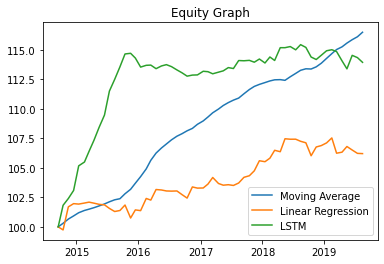

In [ ]:
plt.plot(timestamps, MA_equity,  label = "Moving Average")
plt.plot(timestamps, LR_equity, label = "Linear Regression")
plt.plot(timestamps, LSTM_equity, label = "LSTM")
plt.title("Equity Graph")
plt.legend()
plt.show();

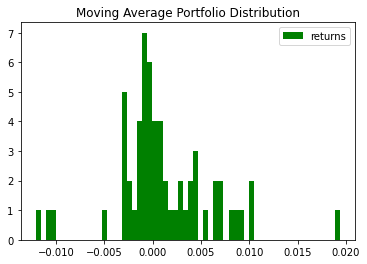

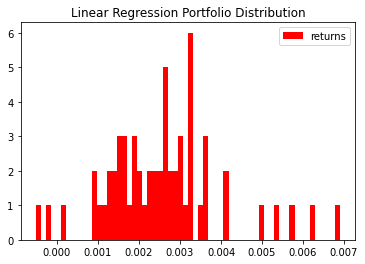

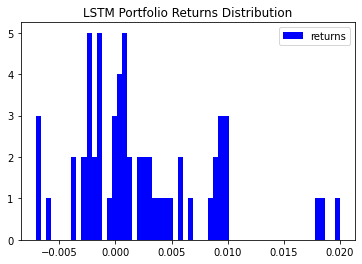

In [ ]:
plt.hist(LR_scipy_returns, bins = 60, label = 'returns', alpha = 1, color = 'green')
plt.title("Moving Average Portfolio Distribution")
plt.legend()
plt.show();
plt.hist(MA_scipy_returns, bins = 60, label = 'returns', alpha = 1, color = 'red')
plt.title("Linear Regression Portfolio Distribution")
plt.legend()
plt.show();
plt.hist(scipy_returns, bins = 60, label = 'returns', alpha = 1, color = 'blue') 
plt.title("LSTM Portfolio Returns Distribution")
plt.legend()
plt.show();

In [ ]:
print("Moving Average Ending Equity: " , MA_equity[-1])
print("Linear Regression Ending Equity: " , LR_equity[-1])
print("LSTM Ending Equity" , LSTM_equity[-1])

Moving Average Ending Equity:  116.49663818994863
Linear Regression Ending Equity:  106.20894472375005
LSTM Ending Equity 113.94521431740938


In [ ]:
import math
def metrics(returns): 
  sharpe = returns.mean() / returns.std()
  annualized_sharpe = sharpe.item() / math.sqrt(252)

  stdev = returns.std() 
  annualized_vol = stdev.item() / math.sqrt(252)


  return {"Annualized Sharpe Ratio": annualized_sharpe,
          "Annualized Volatility": annualized_vol}

In [ ]:
#Annualized info for Moving Average
metrics(np.array(MA_scipy_returns))

{'Annualized Sharpe Ratio': 0.11566522072352636,
 'Annualized Volatility': 8.816512605963443e-05}

In [ ]:
#Annualized info for Linear Regression
metrics(np.array(LR_scipy_returns))

{'Annualized Sharpe Ratio': 0.013885548251160982,
 'Annualized Volatility': 0.00031944580646156226}

In [ ]:
#Annualized info for LSTM
metrics(np.array(scipy_returns))

{'Annualized Sharpe Ratio': 0.024306122192182564,
 'Annualized Volatility': 0.00036847707924741503}

$$